# Hyperparameter testing for ANN

We start by importing the necessary libraries and setting the random seed for reproducibility.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger


In [2]:
seed = 78 # random seed, used for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


We now download the dataset and prepare it before training

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),               # random crop for augmentation
    transforms.RandomHorizontalFlip(),                  # horizontal flip for augmentation
    transforms.ToTensor(),                              # convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),      # normalize by mean and std per channel
                         (0.2470, 0.2435, 0.2616))      #These values come from "https://github.com/kuangliu/pytorch-cifar/issues/19" where the values for normalization were computed
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])


In [4]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=False,
    download=True,
    transform=transform_test
)

With both datasets separated, we can now create dataloaders for each dataset

In [5]:
BATCH_SIZE = 64

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Finally, we will use these loaders and datasets to train our ANN model.

In [6]:
class LitANN(pl.LightningModule):
    def __init__(self, input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = x.view(x.size(0), -1)          # flatten for ANN
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc', acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', acc, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)


In [9]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=3, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 16.5 K | train
2 | fc3  | Linear | 1.3 K  | train
----------------------------------------
411 K     Trainable params
0         Non-trainable params
411 K     Total params
1.645     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:14<00:00, 47.85it/s, v_num=0] 

Metric val_loss improved. New best score: 1.893


Epoch 1: 100%|██████████| 704/704 [00:20<00:00, 33.80it/s, v_num=0]

Metric val_loss improved by 0.118 >= min_delta = 0.005. New best score: 1.775


Epoch 2: 100%|██████████| 704/704 [00:20<00:00, 34.29it/s, v_num=0]

Metric val_loss improved by 0.061 >= min_delta = 0.005. New best score: 1.714
`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 704/704 [00:20<00:00, 34.26it/s, v_num=0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 206.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4050999879837036
        test_loss           1.6890097856521606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.6890097856521606, 'test_acc': 0.4050999879837036}]

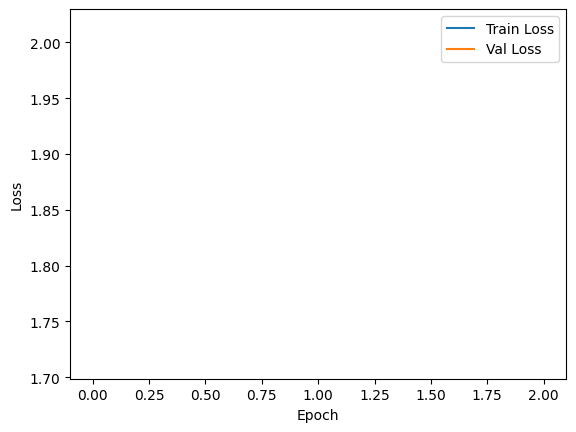

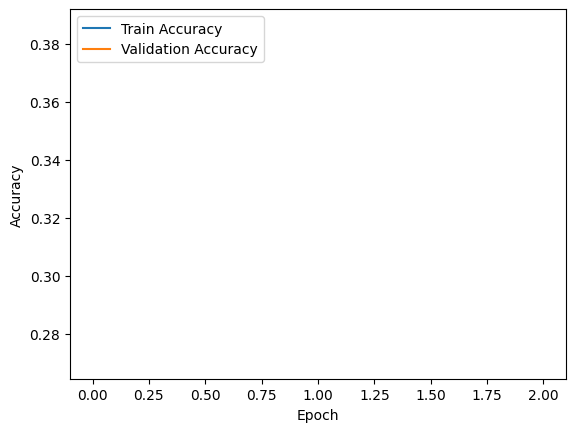

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "Hyperparameters_testing_ANN\logs\ANN\version_0\metrics.csv"
df = pd.read_csv(csv_path)

# Loss plot
plt.plot(df['epoch'], df['train_loss_epoch'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.plot(df['epoch'], df['train_acc_epoch'], label='Train Accuracy')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



As we can see, the results are insatisfactory. The current hyperparameters are not able to capture the complexity of the data ()